In [3]:
import numpy as np

import tensorflow as tf

from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation.pennylane_kernel import PennylaneKernel
from quask.evaluator import HaarEvaluator, LieRankEvaluator

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

import matplotlib.pyplot as plt
import matplotlib as mpl

c:\Users\HP\anaconda3\envs\olqti24\Lib\site-packages\quask\evaluator\haar_evaluator.py:24: SyntaxWarning: invalid escape sequence '\k'
  """


# Importance of Kernel Bandwidth in QML

## Fashion-MNIST Dataset

The Fashion-MNIST dataset is an image classification for distinguishing clothing items. We follow the preprocessing of the input data as done in [The power of data in Quantum Machine Learning](https://arxiv.org/abs/2011.01938). We use Principal Component Analysis (PCA) to reduce each image to an $n$-dimensional vector, the so-called **feature** vector.

Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12000
Number of filtered test examples: 2000
True


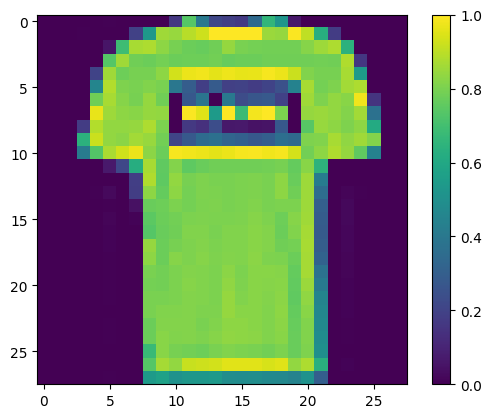

In [4]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

In [5]:
# =============================================================================
# Create dataset
# =============================================================================  
def create_dataset(N_TRAIN, features_DIM):
    """
    create dataset

    This function loads data from the fashion_mnist and manipulates
    data to suit our problem, e.g. normalization.

    N_TRAIN: n° of training data to teach our ML model
    features_DIM: n° of features will have each datum. It corresponds to
                  the number of qubits once the encoding is performed
    save: by default will save the dataset created. Can be disabled to 
          create dummy datasets for testing.

    """
    # print('Loading data...')
    # data loading
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # convert to float in order to normalize the values of the features
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # normalization of the features from [0,255] to [0,1]
    X_train /= 255
    X_test /= 255
    
    # select only two classes to have a binary classification problem
    # =============================================================================
    # filter 0-3
    # =============================================================================
    def filter_03(x, y):
        """
        filter 0-3

        This function keeps only the dresses and t-shorts of the
        fashion mnist dataset in order to have only a binary classification problem

        x: datapoint vector
        y: target/label vector relative to the x vector

        """
        keep = (y == 0) | (y == 3)
        x, y = x[keep], y[keep]
        y = y == 0
        return x,y
    
    # apply the filter 
    X_train, y_train = filter_03(X_train, y_train)
    X_test, y_test = filter_03(X_test, y_test)
    # =============================================================================
    # Truncate x
    # =============================================================================
    def truncate_x(X_train, X_test, n_components=features_DIM):
        """
        truncate x

        Perform PCA on image dataset keeping the top `n_components` components.
        
        X_train: training dataset
        X_test: test dataset
        n_components: number of features we want to keep after PCA

        """
        n_points_train = tf.gather(tf.shape(X_train), 0)
        n_points_test = tf.gather(tf.shape(X_test), 0)

        # Flatten to 1D
        X_train = tf.reshape(X_train, [n_points_train, -1])
        X_test = tf.reshape(X_test, [n_points_test, -1])

        # Normalize.
        feature_mean = tf.reduce_mean(X_train, axis=0)
        X_train_normalized = X_train - feature_mean
        X_test_normalized = X_test - feature_mean

        # Truncate.
        e_values, e_vectors = tf.linalg.eigh(
          tf.einsum('ji,jk->ik', X_train_normalized, X_train_normalized))
        return tf.einsum('ij,jk->ik', X_train_normalized, e_vectors[:,-n_components:]), \
          tf.einsum('ij,jk->ik', X_test_normalized, e_vectors[:, -n_components:])

    # truncating datasets
    X_train, X_test = truncate_x(X_train, X_test, n_components=features_DIM)
    
    print(f'New datapoint dimension:', len(X_train[0]))    

    # restrict the dataset to a smaller ensemble
    N_TEST = round(N_TRAIN*0.2)
    X_train, X_test = X_train[:N_TRAIN], X_test[:N_TEST]
    y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

    print('Number of datapoints', len(X_train))
    
    X_train = np.reshape(X_train, (len(X_train), features_DIM))
    X_test = np.reshape(X_test, (len(X_test), features_DIM))

    print('Data loaded.')
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=800, features_DIM=5)
X_test.shape

New datapoint dimension: 5
Number of datapoints 800
Data loaded.


(160, 5)

## The Quantum Feature Map

Actually, the number of features for one image (thus, one circuit embedding) could be bigger than the number of qubits $d$ according to the feature map we pick. In this case we again refer to a well known feature map called Instantaneous Quantum Polynomial (IQP) feature map. 

$$|\textbf{x}_i\rangle = U_{Z}(\textbf{x}_i) H^{\otimes d} U_{Z}(\textbf{x}_i) H^{\otimes d}|0^d\rangle$$

where

$$ U_{Z}(\textbf{x}_i) = \text{exp} \left( \sum_{j=1}^d \lambda x_{ij}Z_j + \sum_{j=1}^d \sum_{j'=1}^d \lambda^2 x_{ij} x_{ij'} Z_j Z_{j'} \right) \quad . $$

Then, our feature array contains both the single-qubit and two-qubit features (the product of the single-qubit features pair entangled by the map scheme).

$$ \textbf{x}_i = (x_{i1}\;, x_{i2}\;, ..., x_{id}\;, x_{i1}x_{i2}\;, x_{i1}x_{i3}\;, ..., x_{id-1}x_{id}\;) .$$

The number of additional features depends on the type of entanglement we choose. A full entanglement brings to an additional number of features equal to $\binom{d}{2}$. Finally, the total number of features for a single datapoint (as in, image) equals to $d + \binom{d}{2}$.

In [7]:
def create_pennylane_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return PennylaneKernel(ansatz, measurement, type, device_name="default.qubit", n_shots=None)

KernelFactory.add_implementation('pennylane_noiseless', create_pennylane_noiseless)
KernelFactory.set_current_implementation('pennylane_noiseless')
print(KernelFactory._KernelFactory__implementations)
print(KernelFactory._KernelFactory__current_implementation)

{'pennylane_noiseless': <function create_pennylane_noiseless at 0x000002208B006980>}
pennylane_noiseless


In [35]:
def UZCirquit(ansatz, bandwidth, count=0):
    d = ansatz.n_qubits
    # Z term - local
    for k in range(d):
        ansatz.change_operation(count, new_feature=k, new_wires=[k, (k+1)%d], new_generator="ZI", new_bandwidth=bandwidth)
        count += 1

    # ZZ term - full entanglement 
    for i in range(d-1):
        for j in range(i+1, d):
            ansatz.change_operation(count, new_feature=k+i, new_wires=[i, j], new_generator="ZZ", new_bandwidth=bandwidth)
            count += 1

    return ansatz, count

def HCircuit(ansatz, bandwidth=1, count=0):
    d = ansatz.n_qubits
    n_features = d + d*(d-1)/2 + 1 # we have the last feature fixed to one for non-parametrizable gates
    for i in range(d):
        ansatz.change_operation(count, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="XI", new_bandwidth=np.pi/2) # R_x(pi/2)
        ansatz.change_operation(count, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="ZI", new_bandwidth=np.pi/2) # R_z(pi/2)
        ansatz.change_operation(count, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="XI", new_bandwidth=np.pi/2) # R_x(pi/2)
        ansatz.change_operation(count, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="II", new_bandwidth=np.pi)   # e^(i pi/2)

    return ansatz, count

def IQPCirquit(ansatz, bandwidth):
    # first U_Z(x_i)
    ansatz_uz1, count_uz1 = UZCirquit(ansatz, bandwidth)
    # first layer of hadamard gates
    ansatz_uz1h1, count_uz1h1 = HCircuit(ansatz_uz1, bandwidth, count=count_uz1)
    # second U_Z(x_i)
    ansatz_uz1h1uz2, count_uz1h1uz2 = UZCirquit(ansatz_uz1h1, bandwidth, count=count_uz1h1)
    # second layer of hadamard gates
    ansatz_uz1h1uz2h2, _ = HCircuit(ansatz_uz1h1uz2, bandwidth, count=count_uz1h1uz2)
    return ansatz_uz1h1uz2h2

# we can define a new function to construct the Ansatz since we will loop for different bandwidth values
def VaryingBandwidthKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # we choose a IQPCircuit
    ansatz = IQPCirquit(ansatz, bandwidth)
    # kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)
    kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel

# help funciton to select on which qubit we want to perform our measurement
def measurement_qubit(N_QUBITS, measurement):
    pauli_string = ""
    for i in range(N_QUBITS):
        if i < measurement:
            pauli_string = pauli_string + "I"
        if i == measurement:
            pauli_string = pauli_string + "Z"
        if i > measurement:
            pauli_string = pauli_string + "I"
    return pauli_string

# let us define the Ansatz which implements this
def ManyBodyAnsatz(N_FEATURES, N_QUBITS, N_OPERATIONS, measurement, bandwidth):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # linear CZ entanglement
    for j in range(N_QUBITS-1):
        ansatz.change_operation(j, new_feature=N_QUBITS+j, new_wires=[j, j+1], new_generator="ZZ", new_bandwidth=bandwidth)

    # single qubit rotations in x: RX wall
    for i in range(N_QUBITS):
        j += 1
        ansatz.change_operation(j, new_feature=i, new_wires=[i, (i+1)%N_QUBITS], new_generator="XI", new_bandwidth=bandwidth)
    # kernel = KernelFactory.create_kernel(ansatz, measurement_qubit(N_QUBITS=N_QUBITS, measurement=measurement), KernelType.OBSERVABLE)
    kernel = KernelFactory.create_kernel(ansatz, "I" * N_QUBITS, KernelType.OBSERVABLE)
    # kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)
    return kernel

def LinearQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # single qubit rotations in x: RX wall
    for i in range(N_QUBITS):
        ansatz.change_operation(i, new_feature=i, new_wires=[i, (i+1)%N_QUBITS], new_generator="XI", new_bandwidth=bandwidth)
    kernel = KernelFactory.create_kernel(ansatz, "I" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel

## Embedding the datapoints

The number of operations we have to perform following the `IPQCircuit` map are:

$$ \underbrace{\left(d + \frac{d(d-1)}{2} \right)}_{U_{Z}(\textbf{x}_i)} + \underbrace{d}_{H^{\otimes d}} + \underbrace{\left(d + \frac{d(d-1)}{2} \right)}_{U_{Z}(\textbf{x}_i)} + \underbrace{d}_{H^{\otimes d}} $$

which is simpy:

$$ d^2 + 3 d \quad .$$

In [9]:
# modify the datapoints for quask

def quask_features_iqp(data, bandwidth):
    new_data = []
    for datapoint in data:
        new_datapoint = datapoint
        for i in range(len(datapoint)-1):
            for j in range(i+1, len(datapoint)):
                new_datapoint = np.append(new_datapoint, bandwidth*datapoint[i]*datapoint[j])
        new_datapoint = np.append(new_datapoint, 1)
        new_data.append(new_datapoint)
    new_data = np.array(new_data)
    return new_data

def quask_features_qmb(data):
    new_data = []
    for datapoint in data:
        new_datapoint = datapoint
        for i in range(len(datapoint)-1):
            new_datapoint = np.append(new_datapoint, datapoint[i]*datapoint[i+1])
        new_data.append(new_datapoint)
    new_data = np.array(new_data)
    return new_data

In [20]:
def accuracy_computation(K_train, K_test, y_train, y_test):
    # Train the SVC classifier using the precomputed kernel matrices
    svc_kern = SVC(kernel='precomputed')
    svc_kern.fit(K_train, y_train)

    # Predict and evaluate accuracy on the test set
    y_pred = svc_kern.predict(K_test)
    return accuracy_score(y_test, y_pred)

In [53]:
num_datapoints = [100,500,1000]
n_tr = 800
num_qubits = [3,5,7,9,11,13,15,17,19,21,23]
# let us sweep for different values of the bandwidth
bandwidths = np.logspace(-3,0, 15).tolist()
accuracy_qubit = []
for d in num_qubits:
# for n_tr in num_datapoints:
    features_quask = d + d*(d-1)/2 + 1
    # features_quask = 2*d - 1
    operations_quask = d**2 + 3*d 
    # operations_quask = 2*d - 1 

    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d)
    print(f"Original shape of the data: {X_train.shape}")

    # X_train_q = quask_features_qmb(X_train)
    # X_test_q = quask_features_qmb(X_test)
    print(f"Shape of the data for the embedding: {X_train_q.shape}, features of quask: {features_quask}")
    accuracy_beta = []
    for beta in bandwidths:
        # X_train_q = quask_features_iqp(X_train, beta)
        # X_test_q = quask_features_iqp(X_test, beta)
        print(f"Qubits: {d}, beta: {beta}")
        # kernel = VaryingBandwidthKernel(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta)
        print("building training kernel...")
        # K_train = kernel.build_kernel(X_train_q, X_train_q)
        K_train = rbf_kernel(X_train, X_train, gamma=beta)
        print("building testing kernel...")
        K_test = rbf_kernel(X_test, X_train, gamma=beta)
        # K_test = kernel.build_kernel(X_test_q, X_train_q)
        print("computing accuracy...")
        accuracy = accuracy_computation(K_train, K_test, y_train, y_test)
        accuracy_beta.append(accuracy)
    accuracy_qubit.append(accuracy_beta)

    # # for beta in bandwidths:
    #     print(f"Qubits: {d}, beta: {beta}")
    #     kernel = ManyBodyAnsatz(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta, measurement=2)
    #     # kernel = VaryingBandwidthKernel(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta)
    #     print("building training kernel...")
    #     K_train = kernel.build_kernel(X_train_q, X_train_q)
    #     print("building testing kernel...")
    #     K_test = kernel.build_kernel(X_test_q, X_train_q)
    #     print("computing accuracy...")
    #     accuracy = accuracy_computation(K_train, K_test, y_train, y_test)
    #     accuracy_beta.append(accuracy)
    # accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 800
Data loaded.
Original shape of the data: (800, 3)
Shape of the data for the embedding: (100, 13), features of quask: 7.0
Qubits: 3, beta: 0.001
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0016378937069540646
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0026826957952797246
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.004393970560760791
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0071968567300115215
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.011787686347935873
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.019306977288832496
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.031622776601683

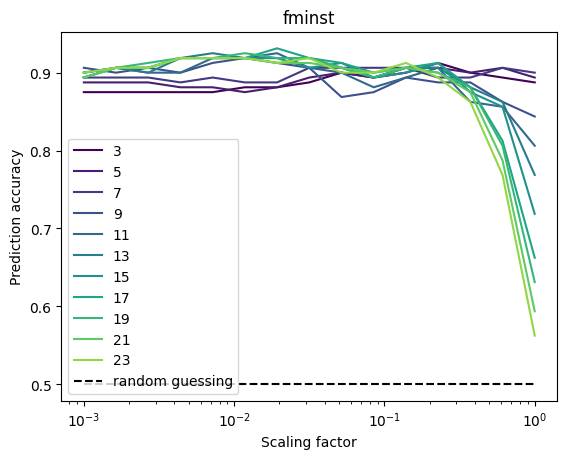

In [59]:
# ---------------------------------------------------------------------------------------
# Create Sequential Colors
# ---------------------------------------------------------------------------------------
def create_sequential_colors(num_colors, colormap_name: str='viridis'):
    """
    create_sequential_colors

    This function creates a sequence of colors extracted from a specified colormap.

    num_colors: int - number of colors we want to extract
    colormap_name: string - colormap name we want to use

    """
    colormap = mpl.colormaps[colormap_name]
    colormap_values = np.linspace(0, 1, num_colors)
    colors = [colormap(value) for value in colormap_values]
    return colors

colors = create_sequential_colors(len(num_qubits)+2)

i = 0
for accuracy_beta, d in zip(accuracy_qubit, num_qubits):
# for accuracy_beta, d in zip(accuracy_qubit, num_datapoints):
    plt.plot(bandwidths, accuracy_beta, color=colors[i], label=f"{d}")
    i += 1
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=1e-3, xmax=1e0, linestyles='--', colors='black', label="random guessing")
plt.legend()

In [44]:
num_qubits = [3,5,7]
n_tr = 100
# let us sweep for different values of the bandwidth
bandwidths = np.logspace(-3,0, 15).tolist()
cost_he_qubit = []
cost_lre_qubit = []
accuracy_qubit = []
for d in num_qubits:
    features_quask = int(d + d*(d-1)/2 + 1)
    operations_quask = int(d**2 + 3*d)
    features_quask = int(2*d - 1)
    operations_quask = int(2*d - 1)
    
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d)
    cost_he_beta = []
    cost_lre_beta = []
    accuracy_beta = []
    X_train_q = quask_features_qmb(X_train)
    X_test_q = quask_features_qmb(X_test)
    for beta in bandwidths:
        # X_train_q = quask_features_iqp(X_train, beta)
        # X_test_q = quask_features_iqp(X_test, beta)
        print(f"Qubits: {d}, beta: {beta}")
        # kernel = VaryingBandwidthKernel(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta)
        # kernel = ManyBodyAnsatz(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta, measurement=0)
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        print("building training kernel...")
        # K_train = kernel.build_kernel(X_train_q, X_train_q)
        K_train = kernel.build_kernel(X_train, X_train)
        # K_train = rbf_kernel(X_train, X_train, gamma=beta)
        K_train_lin = linear_kernel(beta*X_train, beta*X_train)
        print("building testing kernel...")
        # K_test = rbf_kernel(X_test, X_train, gamma=beta)
        K_test_lin = linear_kernel(beta*X_test, beta*X_train)
        # K_test = kernel.build_kernel(X_test_q, X_train_q)
        K_test = kernel.build_kernel(X_test, X_train)

        accuracy = accuracy_computation(K_train_lin, K_test_lin, y_train, y_test)
        accuracy_beta.append(accuracy)

        print("Haar evaluator...")
        he = HaarEvaluator(n_bins=40, n_samples=n_tr)
        cost_he = he.evaluate(kernel=kernel, K=K_train, X=None, y=None)
        print("Lie Rank evaluator...")
        lre = LieRankEvaluator(T=500)
        cost_lre = lre.evaluate(kernel=kernel, K=None, X=None, y=None)
        cost_he_beta.append(cost_he)
        cost_lre_beta.append(cost_lre)
    cost_he_qubit.append(cost_he_beta)
    cost_lre_qubit.append(cost_lre_beta)
    accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 100
Data loaded.
Qubits: 3, beta: 0.001
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.0016378937069540646
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.0026826957952797246
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.004393970560760791
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.0071968567300115215
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.011787686347935873
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.019306977288832496
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta:

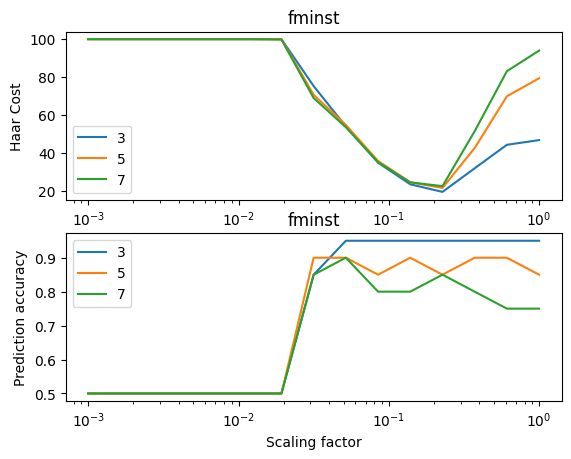

In [45]:
fig, axs = plt.subplots(2,1)
for cost_he, d in zip(cost_he_qubit, num_qubits):
    axs[0].plot(bandwidths, cost_he, label=f"{d}")
axs[0].set_xscale('log')
axs[0].set_title("fminst")
axs[0].set_xlabel("Scaling factor")
axs[0].set_ylabel("Haar Cost")
axs[0].legend()
for acc, d in zip(accuracy_qubit, num_qubits):
    axs[1].plot(bandwidths, acc, label=f"{d}")
axs[1].set_xscale('log')
axs[1].set_title("fminst")
axs[1].set_xlabel("Scaling factor")
axs[1].set_ylabel("Prediction accuracy")
axs[1].legend()